In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO',
'B', 'LSTAT', 'MEDV']
df = pd.read_csv("../input/boston-house-prices/housing.csv", delim_whitespace=True, names=names)

**EDA**

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


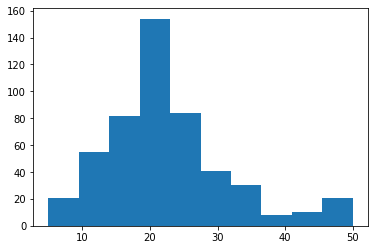

In [3]:
display(df)
plt.hist(df["MEDV"]);

**Feature Selection**

<AxesSubplot:>

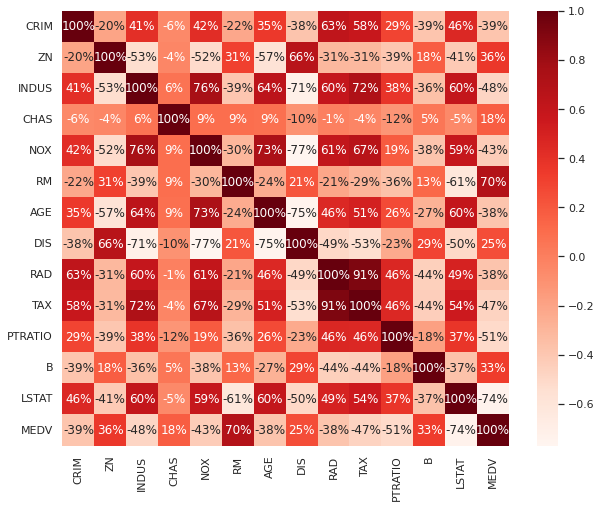

In [4]:
plt.figure(figsize=(10,8))
cm = df.corr()
sns.set(font_scale=1)
sns.heatmap(cm,annot=True,cmap= plt.cm.Reds,fmt= ".0%")

INDUS, RM, TAX, PTRATIO and LSTAT has good corralation with target feature MEDV. But INDUS also has high correlation with LTSAT and TAX. So in this case i should not use INDUS. The best features are RM, TAX, PTRATIO and LSTAT.

In [5]:
df = df[["ZN", "CHAS", "RM","B", "MEDV"]]
display(df)

,ZN,CHAS,RM,B,MEDV
0,18.0,0,6.575,396.90,24.0
1,0.0,0,6.421,396.90,21.6
2,0.0,0,7.185,392.83,34.7
3,0.0,0,6.998,394.63,33.4
4,0.0,0,7.147,396.90,36.2
...,...,...,...,...,...
501,0.0,0,6.593,391.99,22.4
502,0.0,0,6.120,396.90,20.6
503,0.0,0,6.976,396.90,23.9
504,0.0,0,6.794,393.45,22.0


**Normalization**

In [6]:
df = (df - df.mean()) / df.std()

In [7]:
def train_test_split(df,test_size,shuffle): # from scratch 
    if shuffle:
        df = df.reindex(np.random.permutation(df.index))
    total_sample_size= len(df)
    train_end = round(total_sample_size*(1-test_size))
    train = df[0:train_end]
    test = df[train_end:total_sample_size]
    return train,test

def cross_validation(df,fold,train_size,feature_count): # from scratch 
    dataset_size = len(df) 
     
    division_num = 1//(1-train_size)
    kfold = np.zeros((dataset_size//fold,feature_count), dtype=int)
    val_size = int(dataset_size*(1-train_size))
    train_size = int(dataset_size*train_size)
    val = np.zeros((val_size,feature_count),dtype=int)
    train = np.zeros((train_size,feature_count),dtype=int)
    
    for i in range(fold):
        kfold = np.append(kfold,df[i*(dataset_size//fold):((i+1)*dataset_size//fold)-1].to_numpy(),axis=0)
        # first column is zero
        val = np.append(val,kfold[int((i+1)*dataset_size//fold):int((i+1)*dataset_size//fold + val_size//fold )-1],axis=0)
        train = np.append(train,kfold[int((i+1)*dataset_size//fold + val_size//fold ):int((i+1)*dataset_size//fold + val_size//fold + train_size//fold)-1],axis=0)
    val = np.delete(val,np.linspace(0,val_size-1,val_size,dtype=int),0)
    train = np.delete(train,np.linspace(0,train_size-1,train_size,dtype=int),0)
    return train, val

train, test = train_test_split(df,test_size=0.16,shuffle=True)  
train, val = cross_validation(train,fold=5,train_size = 0.79,feature_count=5)

df_train = pd.DataFrame(train,columns=df.columns)
df_val = pd.DataFrame(val,columns=df.columns)
df_test = pd.DataFrame(test,columns=df.columns)
total_data_size = len(df)

x_train, y_train = df_train.drop(columns="MEDV").values.tolist(),df_train.MEDV.values.tolist()
x_val, y_val = df_val.drop(columns="MEDV").values.tolist(),df_val.MEDV.values.tolist()
x_test, y_test = df_test.drop(columns="MEDV").values.tolist(),df_test.MEDV.values.tolist()

print("Train ratio: %",len(train)/total_data_size*100)
print("Test ratio: %",len(test)/total_data_size*100)
print("Validation ratio: %",len(val)/total_data_size*100)
print("Train/Test ratio: %",len(train)/(len(train)+len(test))*100,"- %", len(test)/(len(train)+len(test))*100)
# requested train/test ratio was %80 - %20

Train ratio: % 64.03162055335969
Test ratio: % 16.007905138339922
Validation ratio: % 15.810276679841898
Train/Test ratio: % 80.0 - % 20.0


In [8]:
def mean_squared_error(y_true,y_pred):
    mse = np.square(np.subtract(y_true,y_pred)).mean()
    return mse

In [9]:
def r_squared(y_true,y_pred):
    mse_model = mean_squared_error(y_true,y_pred) # variance of model
    mse_baseline = mean_squared_error(np.mean(y_true),y_true) # variance of target variable
    # R-Squared
    r2_score = 1 - (mse_model/mse_baseline)
    return r2_score

In [10]:
def adjusted_r_squared(y_true,y_pred,num_features,num_samples):
    r2 = r_squared(y_true,y_pred)
    # Adjusted R-Squared
    adjusted_r_squared = 1- (1 - r2)*((num_samples-1)/(num_samples-num_features+1))
    return adjusted_r_squared

In [11]:
class NeuralNetwork:
    
    def __init__(self): 
        
        '''        
        Initial weights and biases assigned random values ranging '0' to '1'. 
        We have a total of 9 weights and 4 biases.
        6 weights are coming in the hidden layer, two for each neuron, hence 3 x 2 = 6.
        The rest of the weights are coming into the output layer.
        Same story for the biases. Each bias is attached to the neuron in the hidden layer
        and output layer.
        
        output layer has one neuron because its a regression problem
        '''
        # Weights
        self.w1, \
        self.w2, \
        self.w3, \
        self.w4, \
        self.w5, \
        self.w6, \
        self.w7, \
        self.w8, \
        self.w9, \
        self.w10, \
        self.w11, \
        self.w12, \
        self.w13, \
        self.w14, \
        self.w15, \
        self.w16, \
        self.w17, \
        self.w18, \
        self.w19, \
        self.w20 = np.random.rand(20)

        # Biases
        self.b_n1, \
        self.b_n2, \
        self.b_n3, \
        self.b_n4, \
        self.b_y_hat = np.random.rand(5) 

    # Activation function for the neurons
    # Each neuron IS an actually activation function itself
    # sigmoid is for forward propagation, sigmoid derivative is for back propagation
    def sigmoid(self, x): return 1 / (1 + np.e**-x)
    def sigmoid_der(self, x): return self.sigmoid(x) * (1 - self.sigmoid(x))

    
    '''
    Feedforward function produces result of the network prediction for each sample.
    First we find neurons' values for hidden layer, then for output layer.
    
    'the optimal size of the hidden layer is usually between the size of the input and size of the output layers'. 
    Jeff Heaton, the author of Introduction to Neural Networks in Java, offers a few more.

    for most problems, one could probably get decent performance (even without a second optimization step) by setting
    the hidden layer configuration using just two rules: (i) the number of hidden layers equals one;
    and (ii) the number of neurons in that layer is the mean of the neurons in the input and output layers.
    
    (4 + 1)/2 = 2.5, 3 neuron for hidden layer should be enough
    '''
    def feedforward(self, x):
        
        # x[0], x[1] - features
        # n* - neurons in the hidden layer, y_hat - predicted value
        self.n1    = self.sigmoid(x[0]*self.w1 + x[1]*self.w2 + + x[2]*self.w3 + x[3]*self.w4 + self.b_n1) 
        self.n2    = self.sigmoid(x[0]*self.w5 + x[1]*self.w6 + + x[2]*self.w7 + x[3]*self.w8 + self.b_n2) 
        self.n3    = self.sigmoid(x[0]*self.w9 + x[1]*self.w10 + + x[2]*self.w11 + x[3]*self.w12 + self.b_n3)
        self.n4    = self.sigmoid(x[0]*self.w13 + x[1]*self.w14 + + x[2]*self.w15 + x[3]*self.w16 + self.b_n4) 
    
        self.y_hat = self.sigmoid(self.n1*self.w17 + self.n2*self.w18 + self.n3*self.w19 + self.n4*self.w20 + self.b_y_hat)

    
    '''
    Backpropagation updates all the weights and biases of the network.
    By using Gradient Descent technique, each trainable parameter (weight or bias)
    is changing a little bit towards minimum of MSE.
    Unlike forward propagation, we tweak our parameters starting
    from the right end of the network, meaning first we update
    weights and biases for output layer, then for the hidden.
    If we had more than one hidden layer, we would go over them 
    is similar fashion, 
    like this: "output layer" => "hidden layer 2" => "hidden layer 1"
    '''
    def backpropagation(self, x, y):

        # We calculate some values here to use them later
        y_hat_der = (-2 * (y-self.y_hat) * self.sigmoid_der(self.n1*self.w13 + self.n2*self.w14 + self.n3*self.w15  + self.b_y_hat))
        n1_der = self.w17 * self.sigmoid_der(x[0]*self.w1 + x[1]*self.w2 + + x[2]*self.w3 + x[3]*self.w4 + self.b_n1)
        n2_der = self.w18 * self.sigmoid_der(x[0]*self.w5 + x[1]*self.w6 + + x[2]*self.w7 + x[3]*self.w8 + self.b_n2)
        n3_der = self.w19 * self.sigmoid_der(x[0]*self.w9 + x[1]*self.w10 + + x[2]*self.w11 + x[3]*self.w12 + self.b_n3)
        n4_der = self.w20 * self.sigmoid_der(x[0]*self.w13 + x[1]*self.w14 + + x[2]*self.w15 + x[3]*self.w16 + self.b_n4)
        
        # Biases
        self.b_n1    -= self.lr * y_hat_der * n1_der
        self.b_n2    -= self.lr * y_hat_der * n2_der
        self.b_n3    -= self.lr * y_hat_der * n3_der
        self.b_n4    -= self.lr * y_hat_der * n4_der
        self.b_y_hat -= self.lr * y_hat_der

        # Weights
        self.w17 -= self.lr * y_hat_der * self.n1
        self.w18 -= self.lr * y_hat_der * self.n2
        self.w19 -= self.lr * y_hat_der * self.n3
        self.w20 -= self.lr * y_hat_der * self.n4
        
        self.w1 -= self.lr * y_hat_der * n1_der * x[0]
        self.w2 -= self.lr * y_hat_der * n1_der * x[1]
        self.w3 -= self.lr * y_hat_der * n1_der * x[2]
        self.w4 -= self.lr * y_hat_der * n1_der * x[3]
        self.w5 -= self.lr * y_hat_der * n2_der * x[0]
        self.w6 -= self.lr * y_hat_der * n2_der * x[1]
        self.w7 -= self.lr * y_hat_der * n2_der * x[2]
        self.w8 -= self.lr * y_hat_der * n2_der * x[3]
        self.w9 -= self.lr * y_hat_der * n3_der * x[0]
        self.w10 -= self.lr * y_hat_der * n3_der * x[1]
        self.w11 -= self.lr * y_hat_der * n3_der * x[2]
        self.w12 -= self.lr * y_hat_der * n3_der * x[3]
        self.w13 -= self.lr * y_hat_der * n4_der * x[0]
        self.w14 -= self.lr * y_hat_der * n4_der * x[1]
        self.w15 -= self.lr * y_hat_der * n4_der * x[2]
        self.w16 -= self.lr * y_hat_der * n4_der * x[3]
        
    
    '''
    Training process is the combination of forward and back propagations.
    '''
    def fit(self, x_train, y_train, x_test, y_test, x_val, y_val, epoch=10, lr=0.01):

        self.lr = lr
        mse_list = []
        train_r2_list = []
        test_r2_list = []
        val_r2_list = []

        # Loop to go over epochs. Each epoch train network on all available data.
        # We also check MSE and store it to visualize training process
        for i in range(epoch):
           
            # Loop to go over each training example for current epoc
            for j in range(len(x_train)):
                self.feedforward(x_train[j])
                self.backpropagation(x_train[j], y_train[j]) 
                
            loop = tqdm(enumerate(x_train),total= len(x_train),leave=False)
            for j in loop:
                
                val_pred = self.predict(x_val)
                train_pred = self.predict(x_train)
                test_pred = self.predict(x_test)

                val_r2_score = r_squared(y_val,val_pred)
                train_r2_score = r_squared(y_train, train_pred)
                test_r2_score = r_squared(y_test, test_pred)
                mse = mean_squared_error(y_train, self.predict(x_train))

                train_r2_list.append(train_r2_score)
                test_r2_list.append(test_r2_score)
                val_r2_list.append(val_r2_score)
                mse_list.append(mse)

                loop.set_description(f"Epoch [{i+1}/{epoch}]")
                loop.set_postfix(mse = f"{round(mse, 4)}",training_score= f"{'{:.4f}%'.format(train_r2_score)}",
                                 test_score= f"{'{:.4f}%'.format(test_r2_score)}", 
                                 validation_score= f"{'{:.4f}%'.format(val_r2_score)}")
            
        print("==========Training finished==========")
        
        return mse_list, train_r2_list, test_r2_list, val_r2_list

    '''
    This function is very similar to feed forward,
    it's in fact uses 'feedforward' function to make predictions.
    The only difference is that we predict outcome for all samples.
    '''
    def predict(self, X):

        result = []

        for x in X:
            self.feedforward(x)
            result.append(self.y_hat)

        return result

In [12]:
model = NeuralNetwork()
# lr_list = [0.001,0.005, 0.01, 0.05]

# plt.figure(figsize=(14,7))
# plt.style.use('seaborn-whitegrid')
# plt.title('Neural Network Training Process', fontsize=15)
# plt.xlabel('Epoch', fontsize=12)
# plt.ylabel('MSE', fontsize=12)

# for lr in lr_list:
#     history = model.fit(x_train, y_train, epoch=100, lr=lr)
#     plt.plot(history,label=f"Learning rate: {lr}")
    
# plt.legend()
# plt.show()
   

In [13]:
epoch = 100

history = model.fit(x_train, y_train, x_test, y_test, x_val, y_val,epoch=epoch, lr=0.05)   

mse_list, train_r2_list, test_r2_list, val_r2_list = history
val_pred = model.predict(x_val)
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

val_r2_score = r_squared(y_val,val_pred)
train_r2_score = r_squared(y_train, train_pred)
test_r2_score = r_squared(y_test, test_pred)

print(f"Validation R-Squared Score:\t {val_r2_score} ")
print(f"Training R-Squared Score:\t {train_r2_score} ")
print(f"Test R-Squared Score:\t\t {test_r2_score} ")

==========Train finished==========
Validation R-Squared Score:	 0.3766572714526354 
Training R-Squared Score:	 0.37710709952297305 
Test R-Squared Score:		 0.2955618560674588 


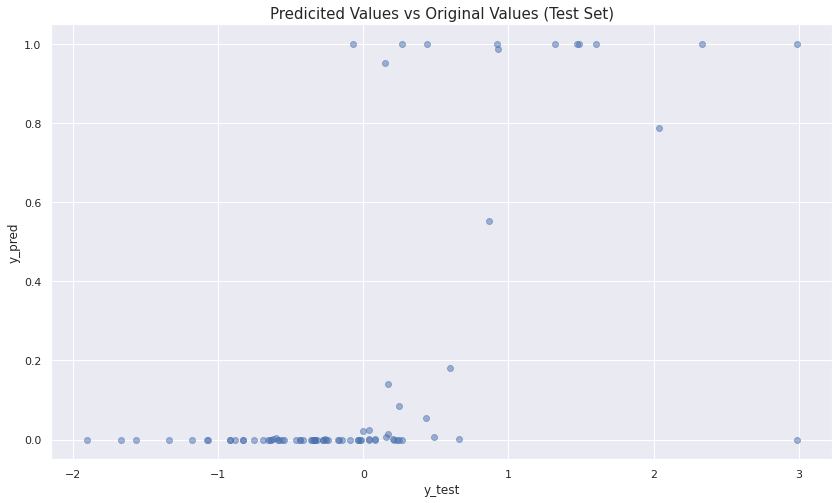

In [14]:
plt.figure(figsize=(14,8))
plt.scatter(x=y_test,y=test_pred,alpha=0.5)
plt.xlabel('y_test',size=12)
plt.ylabel('y_pred',size=12)
plt.title('Predicited Values vs Original Values (Test Set)',size=15)
plt.show()

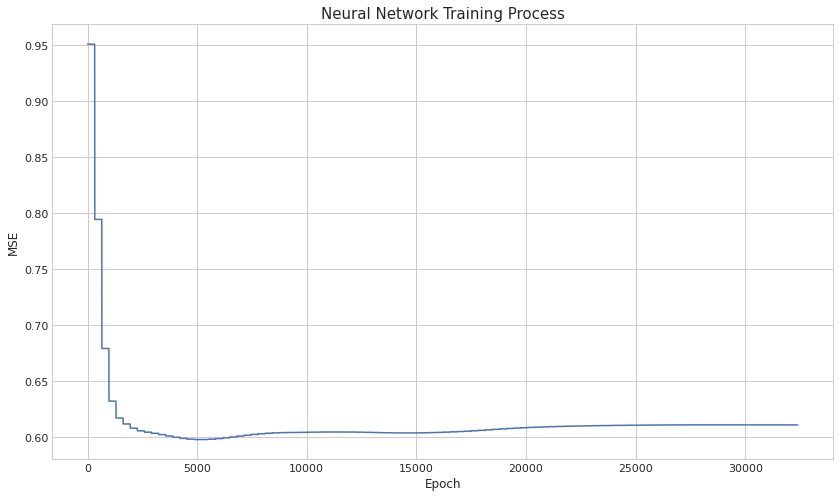

In [15]:
plt.figure(figsize=(14,8))
plt.style.use('seaborn-whitegrid')
plt.title('Neural Network Training Process', fontsize=15)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.plot(mse_list)
    
plt.legend()
plt.show()

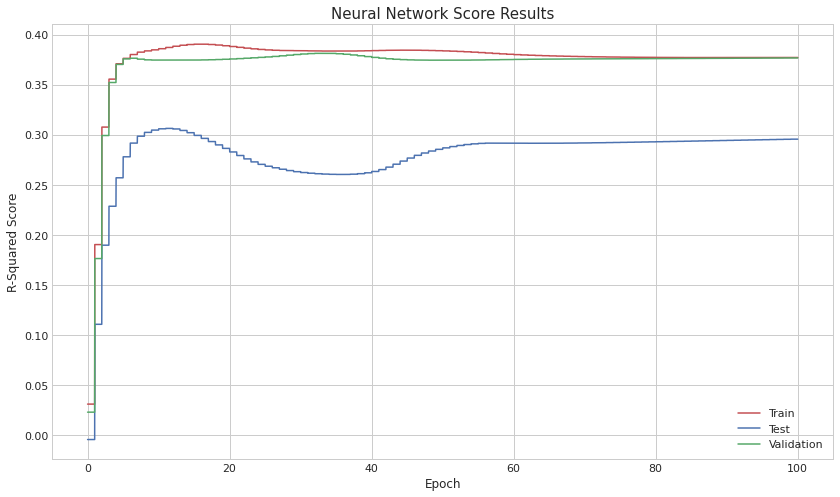

In [16]:
x_axis_train_acc = np.linspace(0,epoch,len(train_r2_list))
x_axis_test_acc = np.linspace(0,epoch,len(test_r2_list))
x_axis_val_acc = np.linspace(0,epoch,len(val_r2_list))

plt.figure(figsize=(14,8)) 
plt.plot(x_axis_train_acc,train_r2_list,'-r',label='Train')
plt.plot(x_axis_test_acc,test_r2_list,'-b',label= 'Test')
plt.plot(x_axis_val_acc,val_r2_list,'-g',label= 'Validation')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('R-Squared Score', fontsize=12)
plt.title('Neural Network Score Results',fontsize=15)
plt.legend()

plt.show()